# Project 2: Linear Classification

### Part 1: Generate Training and Testing Data (2 points)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Generating Training and Testing Data
# Creating a class for the dataset
class Data_set:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov  = cov
    
    def split_data(self):
        np.random.shuffle(self.data)
        self.train = self.data[:len(self.data)//2]
        self.test  = self.data[len(self.data)//2:]
        
        return self
    
    def multivariate_normal(self, num):
        # asself.data.shape = num *  2
        self.data = np.random.multivariate_normal(self.mean,self.cov,size=num)
    
        return self
    
def accuracy(data, w, b):
    false_count = 0
    miss_data    = []
    for index, item in enumerate(data):
        lda_val = np.dot(w,item)
        # class c1
        if index<100 and lda_val<0:
            false_count = false_count + 1
            miss_data   = np.append(miss_data, item)
        # class c2    
        elif index>=100 and lda_val>=0:
            false_count = false_count + 1
            miss_data   = np.append(miss_data, item)
    
    accuracy = 1 - false_count/len(data)
    miss_data = miss_data.reshape(int(len(miss_data)/2),2)
#     print(miss_data.shape)
    
    return accuracy, miss_data



In [2]:
#### Given parameters
mean1 = np.array([1,1])
mean2 = np.array([-1,-1])
cov1 = np.array([[3,2],[2,3]])
cov2 = np.array([[2,-1],[-1,2]])

#### Generating dataset and spliting dataset
c1 = Data_set(mean1,cov1)
c1 = c1.multivariate_normal(200)
c1 = c1.split_data()
# c1.train, c1.test
c2 = Data_set(mean2,cov2)
c2 = c2.multivariate_normal(200)
c2 = c2.split_data()


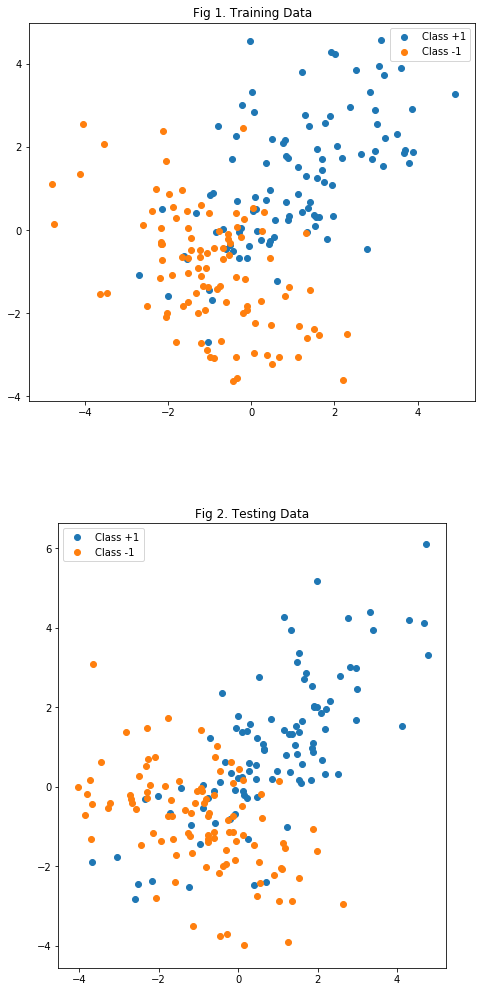

In [3]:
fig = plt.figure(1,figsize=(8,18))

ax_train = fig.add_subplot(211, aspect='equal')
ax_train.scatter(c1.train[:,0], c1.train[:,1], label="Class +1")
ax_train.scatter(c2.train[:,0], c2.train[:,1], label="Class -1")
ax_train.legend()
ax_train.set_title("Fig 1. Training Data")

ax_test  = fig.add_subplot(212, aspect='equal')
ax_test.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax_test.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax_test.legend()
ax_test.set_title("Fig 2. Testing Data")
plt.show()

### Part 2: Linear Discriminant Analysis (5 points)

In [4]:
# Overall mean & covariance
train_data = np.vstack((c1.train, c2.train))
test_data  = np.vstack((c1.test, c2.test))
# mu_est     = [np.mean(train_data[:,0]),np.mean(train_data[:,1])]
cov_est    = np.cov(test_data.T)   # Transopose data to get correct covariance
print("-----Output-----")
# print("The estimate overall mean is", mu_est)
print("The estimate overall covariance is", cov_est)

-----Output-----
The estimate overall covariance is [[3.30644585 1.50145808]
 [1.50145808 3.26985962]]


In [5]:
# Finding weight(w) vector
# w = (mu1 - mu2)*cov_est^T
sample_mean_c1 = np.array([np.mean(c1.train[:,0]),np.mean(c1.train[:,1])])
sample_mean_c2 = np.array([np.mean(c2.train[:,0]),np.mean(c2.train[:,1])])
w              = np.dot((sample_mean_c1 - sample_mean_c2),cov_est**-1)

pi_1           = len(c1.test)/len(test_data)
pi_2           = len(c2.test)/len(test_data)
# First two terms of bias
term1          = 0.5*np.dot(np.dot(sample_mean_c1.T, np.linalg.inv(cov_est)),sample_mean_c1)
term2          = 0.5*np.dot(np.dot(sample_mean_c2.T, np.linalg.inv(cov_est)),sample_mean_c2)

b              = term1 - term2 + np.log(pi_2/pi_1)

print("-----Learned weight and bias-----")
print("Learned weight w is", w)
print("Learned bias b is", b)

-----Learned weight and bias-----
Learned weight w is [2.06999393 2.01177463]
Learned bias b is 0.08176752281808941


-----Accuracy-----
The accuracy is 0.8200000000000001


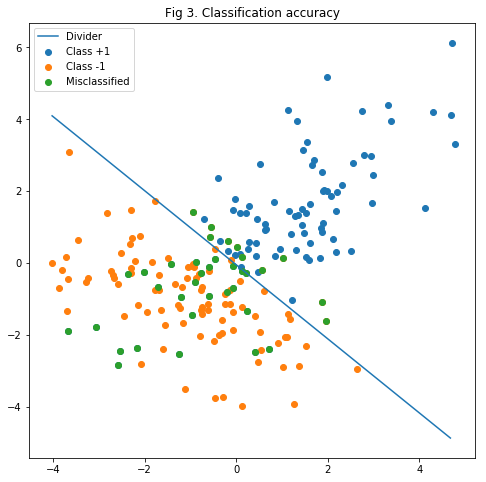

In [6]:
# Classify the test data
x_axis = np.arange(np.min(test_data[:,0]),np.max(test_data[:,0]),0.1)
y_axis = (-b-w[0]*x_axis)/w[1]

acc, miss = accuracy(test_data, w, b)
print("-----Accuracy-----")
print("The accuracy is", acc)

fig2 = plt.figure(2,figsize=(8,8))

ax2 = fig2.add_subplot(111)
ax2.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax2.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax2.scatter(miss[:,0], miss[:,1], label="Misclassified")
ax2.plot(x_axis,y_axis,label="Divider")
ax2.legend()
ax2.set_title("Fig 3. Classification accuracy")
plt.show()

### Part 3: Logistic Regression (10 points)

In [7]:
# Lump a '1' into each data point
ones          = np.ones(len(train_data))[None].T
train_data_1s = np.hstack((ones, train_data))

In [31]:
def IRLS(data):
    length        = len(data)
    not_converged = True
    w             = np.array([0, 0, 0])
    p             = np.empty(length)
    s             = np.ones(length) * 1e-4
    z             = np.empty(length)

    ones = np.ones(200)
    ones[100:200] = ones[100:200]*-1
    y = ones
    
    while not_converged:
        w_prev = w
        for i in range(length):
            p[i] = np.exp(np.dot(w, data[i].T))/(1 + np.exp(np.dot(w, data[i])))
            s[i] = p[i] * (1 - p[i])
            z[i] = np.dot(w, data[i].T) + (y[i]-p[i])/(s[i]+0.001)
            
            print(i, "---", p[i],s[i],z[i])
            
        diag_s = np.diag(s)
        t1     = np.linalg.inv(np.dot(np.dot(data.T, diag_s), data))
        t2     = np.dot(np.dot(data.T, diag_s), z)
        w      = np.dot(t1, t2)
        print('------------',w,'---------------')
        if abs(sum(w-w_prev)) < 0.1:
            not_converged = False
            
    return w
        

In [32]:
# train_data_1s.T.shape
w=IRLS(train_data_1s)

0 --- 0.5 0.25 1.9920318725099602
1 --- 0.5 0.25 1.9920318725099602
2 --- 0.5 0.25 1.9920318725099602
3 --- 0.5 0.25 1.9920318725099602
4 --- 0.5 0.25 1.9920318725099602
5 --- 0.5 0.25 1.9920318725099602
6 --- 0.5 0.25 1.9920318725099602
7 --- 0.5 0.25 1.9920318725099602
8 --- 0.5 0.25 1.9920318725099602
9 --- 0.5 0.25 1.9920318725099602
10 --- 0.5 0.25 1.9920318725099602
11 --- 0.5 0.25 1.9920318725099602
12 --- 0.5 0.25 1.9920318725099602
13 --- 0.5 0.25 1.9920318725099602
14 --- 0.5 0.25 1.9920318725099602
15 --- 0.5 0.25 1.9920318725099602
16 --- 0.5 0.25 1.9920318725099602
17 --- 0.5 0.25 1.9920318725099602
18 --- 0.5 0.25 1.9920318725099602
19 --- 0.5 0.25 1.9920318725099602
20 --- 0.5 0.25 1.9920318725099602
21 --- 0.5 0.25 1.9920318725099602
22 --- 0.5 0.25 1.9920318725099602
23 --- 0.5 0.25 1.9920318725099602
24 --- 0.5 0.25 1.9920318725099602
25 --- 0.5 0.25 1.9920318725099602
26 --- 0.5 0.25 1.9920318725099602
27 --- 0.5 0.25 1.9920318725099602
28 --- 0.5 0.25 1.992031872509

153 --- 0.06035036808733478 0.05670820115905799 -21.119684518643663
154 --- 0.013857683979350716 0.013665648574079162 -73.39641986163805
155 --- 0.0013482871887338349 0.001346469310390531 -433.3543785795232
156 --- 0.005662294944604986 0.005630233360565287 -156.84651295740474
157 --- 0.01183292914090424 0.011692910928850579 -84.14134696966272
158 --- 0.15258587616453237 0.12930342655963437 -10.559861537658495
159 --- 0.5015434995056466 0.24999761760927608 -5.97612778191113
160 --- 0.08510733110419623 0.07786407329651694 -16.134103389691532
161 --- 0.016367175294202632 0.016099290867091474 -63.53511670388365
162 --- 0.005734480050833888 0.005701595789380476 -155.22938687344035
163 --- 0.027586417560562307 0.026825407126736606 -40.49224680297813
164 --- 0.0026798408213141445 0.002672659274486563 -278.93125644035365
165 --- 0.02648000730159222 0.025778816514899845 -41.93631970668084
166 --- 0.042298051327930554 0.040508926181790306 -28.230010364922926
167 --- 0.02015023894531934 0.0197442

52 --- 0.9999998948865643 1.0511342468443843e-07 16.06833072711079
53 --- 1.2421772041368796e-31 1.2421772041368796e-31 928.8367277669572
54 --- 0.9999999998564996 1.4350043373740022e-10 22.664683148402002
55 --- 0.9999998791367772 1.2086320815547128e-07 15.928727048745325
56 --- 2.861422262570023e-29 2.861422262570023e-29 934.2763510989994
57 --- 4.3979529376530925e-09 4.397952918311103e-09 980.753471027165
58 --- 1.0 0.0 118.68610150665648
59 --- 1.080448586623532e-05 1.0804369129320487e-05 977.8648901572309
60 --- 8.988360469267974e-50 8.988360469267974e-50 887.0666758094317
61 --- 1.0 0.0 55.77852224265189
62 --- 0.9999999582873986 4.1712599633037384e-08 16.992504230449395
63 --- 1.0 0.0 43.94450106098758
64 --- 0.9999999999721493 2.7850721728063627e-11 24.304162223536533
65 --- 1.0 0.0 65.80846002847316
66 --- 2.2291126053735864e-05 2.229062915943512e-05 967.4623042155669
67 --- 1.0 0.0 73.92545679979848
68 --- 1.0 0.0 77.51650025793435
69 --- 1.0 0.0 77.3941609171754
70 --- 4.182

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


0.0 -3663.3874178592696
152 --- 0.0 0.0 -4282.074279794725
153 --- 0.0 0.0 -2948.83669711151
154 --- 0.0 0.0 -3943.2489053386926
155 --- 0.0 0.0 -5477.547358005686
156 --- 0.0 0.0 -4534.0065603224875
157 --- 0.0 0.0 -4050.9543278171204
158 --- 0.0 0.0 -2276.3598261817647
159 --- 1.6970484187506656e-65 1.6970484187506656e-65 -1149.1391405267993
160 --- 0.0 0.0 -2706.3453912947357
161 --- 0.0 0.0 -3830.2792611428563
162 --- 0.0 0.0 -4526.646503430214
163 --- 0.0 0.0 -3482.978501338166
164 --- 0.0 0.0 -5025.979317880399
165 --- 0.0 0.0 -3511.636630918581
166 --- 0.0 0.0 -3191.5035640413125
167 --- 0.0 0.0 -3694.505991761592
168 --- 0.0 0.0 -3559.533991639286
169 --- 0.0 0.0 -3347.240616501147
170 --- 0.0 0.0 -4517.75742130758
171 --- 0.0 0.0 -1863.9491797693267
172 --- 0.0 0.0 -3818.400924509937
173 --- 0.0 0.0 -4071.165019761878
174 --- 0.0 0.0 -4945.823448897636
175 --- 0.0 0.0 -3906.4367393780867
176 --- 0.0 0.0 -2809.0742456096577
177 --- 0.0 0.0 -3422.5307305058304
178 --- 0.0 0.0 -3

149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan
185 --- nan nan nan
186 --- nan nan nan
187 --- nan nan nan
188 --- nan nan nan
189 --- nan nan nan
190 --- nan nan nan
191 --- nan nan nan
192 --- nan nan nan
193 --- nan nan nan
194 --- nan nan nan
195 --- nan nan nan
196 --- nan nan nan
197 --- nan nan nan
198 --- nan nan nan


147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan
185 --- nan nan nan
186 --- nan nan nan
187 --- nan nan nan
188 --- nan nan nan
189 --- nan nan nan
190 --- nan nan nan
191 --- nan nan nan
192 --- nan nan nan
193 --- nan nan nan
194 --- nan nan nan
195 --- nan nan nan
196 --- nan nan nan


145 --- nan nan nan
146 --- nan nan nan
147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan
185 --- nan nan nan
186 --- nan nan nan
187 --- nan nan nan
188 --- nan nan nan
189 --- nan nan nan
190 --- nan nan nan
191 --- nan nan nan
192 --- nan nan nan
193 --- nan nan nan
194 --- nan nan nan


143 --- nan nan nan
144 --- nan nan nan
145 --- nan nan nan
146 --- nan nan nan
147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan
185 --- nan nan nan
186 --- nan nan nan
187 --- nan nan nan
188 --- nan nan nan
189 --- nan nan nan
190 --- nan nan nan
191 --- nan nan nan
192 --- nan nan nan


141 --- nan nan nan
142 --- nan nan nan
143 --- nan nan nan
144 --- nan nan nan
145 --- nan nan nan
146 --- nan nan nan
147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan
185 --- nan nan nan
186 --- nan nan nan
187 --- nan nan nan
188 --- nan nan nan
189 --- nan nan nan
190 --- nan nan nan


139 --- nan nan nan
140 --- nan nan nan
141 --- nan nan nan
142 --- nan nan nan
143 --- nan nan nan
144 --- nan nan nan
145 --- nan nan nan
146 --- nan nan nan
147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan
185 --- nan nan nan
186 --- nan nan nan
187 --- nan nan nan
188 --- nan nan nan


137 --- nan nan nan
138 --- nan nan nan
139 --- nan nan nan
140 --- nan nan nan
141 --- nan nan nan
142 --- nan nan nan
143 --- nan nan nan
144 --- nan nan nan
145 --- nan nan nan
146 --- nan nan nan
147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan
185 --- nan nan nan
186 --- nan nan nan


135 --- nan nan nan
136 --- nan nan nan
137 --- nan nan nan
138 --- nan nan nan
139 --- nan nan nan
140 --- nan nan nan
141 --- nan nan nan
142 --- nan nan nan
143 --- nan nan nan
144 --- nan nan nan
145 --- nan nan nan
146 --- nan nan nan
147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan
183 --- nan nan nan
184 --- nan nan nan


133 --- nan nan nan
134 --- nan nan nan
135 --- nan nan nan
136 --- nan nan nan
137 --- nan nan nan
138 --- nan nan nan
139 --- nan nan nan
140 --- nan nan nan
141 --- nan nan nan
142 --- nan nan nan
143 --- nan nan nan
144 --- nan nan nan
145 --- nan nan nan
146 --- nan nan nan
147 --- nan nan nan
148 --- nan nan nan
149 --- nan nan nan
150 --- nan nan nan
151 --- nan nan nan
152 --- nan nan nan
153 --- nan nan nan
154 --- nan nan nan
155 --- nan nan nan
156 --- nan nan nan
157 --- nan nan nan
158 --- nan nan nan
159 --- nan nan nan
160 --- nan nan nan
161 --- nan nan nan
162 --- nan nan nan
163 --- nan nan nan
164 --- nan nan nan
165 --- nan nan nan
166 --- nan nan nan
167 --- nan nan nan
168 --- nan nan nan
169 --- nan nan nan
170 --- nan nan nan
171 --- nan nan nan
172 --- nan nan nan
173 --- nan nan nan
174 --- nan nan nan
175 --- nan nan nan
176 --- nan nan nan
177 --- nan nan nan
178 --- nan nan nan
179 --- nan nan nan
180 --- nan nan nan
181 --- nan nan nan
182 --- nan nan nan


KeyboardInterrupt: 

In [ ]:
acc, miss = accuracy(test_data, w[1:3], w[0])
# w[1:3],w[0]
acc

In [36]:
np.repeat(1,13)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
a1 = np.log(np.log(1.5e24))
a2 = np.log(np.log(1+1.5e24))
tem = np.logaddexp(a1,-a2)
np.exp(tem)

In [ ]:
w = np.array([0, 0, 0])[None]
w.T,w